# Categories

In [9]:
import os
import requests

# Foursquare credentials have been stored in local environment variables
CLIENT_ID = os.environ['FOURSQUARE_CLIENT_ID'] 
CLIENT_SECRET = os.environ['FOURSQUARE_CLIENT_SECRET'] 
VERSION = '20180605' # Foursquare API version

url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}'.format(
            CLIENT_ID,
            CLIENT_SECRET
        )

parameters = {'v':VERSION}

result = requests.get(url, parameters)
print('Response status:', result.status_code)

Response status: 200


In [12]:
contents = result.json()
categories = contents['response']['categories']

### Save categories' database

In [21]:
# import json

# with open('venue-categories.json', 'w') as fw:
#     fw.write(json.dumps(categories, indent=4))

### Vanues' categories will be grouped based on the first layer of the database

In [76]:
print('Categories\' groups:')
cat_grps = []
for i, child in enumerate(categories):
    print('{}. {}'.format(i, child['name']))
    cat_grps.append(child['name'])

Categories' groups:
0. Arts & Entertainment
1. College & University
2. Event
3. Food
4. Nightlife Spot
5. Outdoors & Recreation
6. Professional & Other Places
7. Residence
8. Shop & Service
9. Travel & Transport


### Function to locate position of a category in database

In [47]:
def search(tr, item):
    """
    Locate position of a category in categories' database
    
    @return a tuple with two elements
                1st element is a sequence/list of nodes' indexes which lead to the position of the category
                2nd element is a sequence/list of comparison results of each node 's name with the category
                    if the category is in the database,
                        2nd element will contain a sub-element with value equals to 1
                        E.g.: [0, 0, ..., 1]
                    
    """
    if ((type(tr) is not dict) and (type(tr) is not list)):
        print('First parameter should be a List or a Dictionary!')
        return None
    
    if (type(tr) is dict):
        if ('name' in tr) and (item == tr['name']):
            return (['name'], [1])
        
        if ('categories' in tr) and (0 < len(tr['categories'])):
            result = search(tr['categories'], item)
            if (type(result) is tuple) and (type(result[1]) is list):
                return (['categories'] + result[0], [0] + result[1])

        return ([0], [0])
    else:
        for i, child in enumerate(tr):
            result = search(child, item)
            if (type(result) is tuple) and (type(result[1]) is list) and (1 in result[1]):
                return ([i] + result[0], [0] + result[1])
        return ([0], [0])

In [52]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Tokyo'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Tokyo are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Tokyo are 35.6828387, 139.7594549.


In [53]:
LIMIT = 100
RADIUS = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}'.format(
            CLIENT_ID,
            CLIENT_SECRET
        )

parameters = {
            'v':VERSION,
            'll':'{},{}'.format(latitude, longitude),
            'radius':RADIUS,
            'limit':LIMIT
        }

result = requests.get(url, parameters)
print('Response status:', result.status_code)

Response status: 200


In [67]:
import numpy as np

tokyo_cat_grp = np.zeros((len(categories),), dtype=int)

items = result.json()['response']['groups'][0]['items']
for item in items:
    venue = item['venue']
    venue_cat = venue['categories'][0]['name']
    query_result = search(categories, venue_cat)
    if (1 in query_result[1]):
        tokyo_cat_grp[query_result[0][0]] += 1
    else:
        print('Unknown category:', venue_cat)

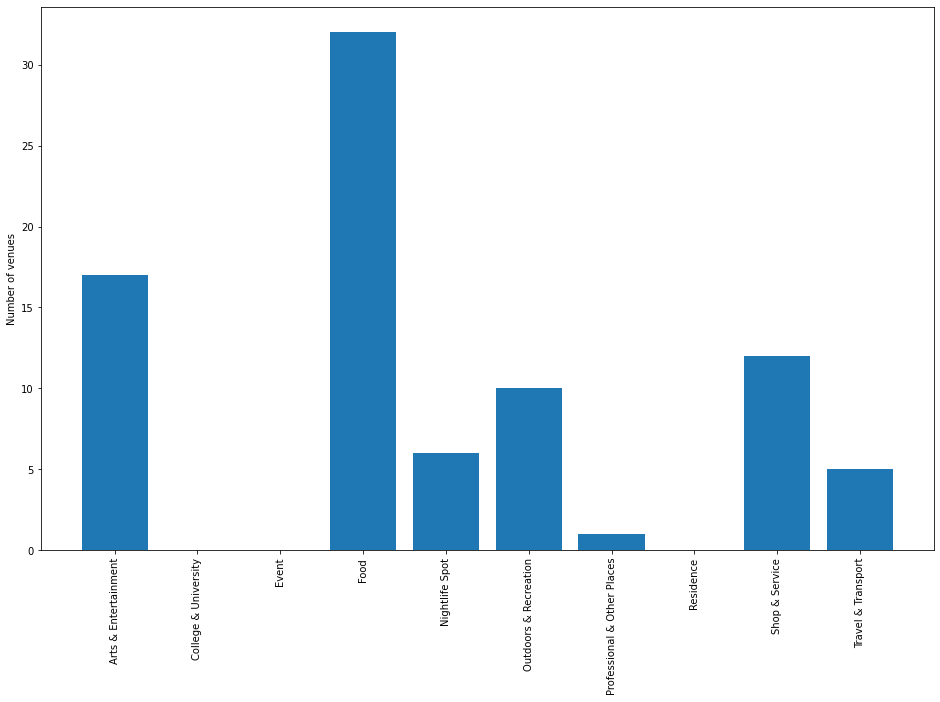

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,10))
ax.bar(cat_grps, tokyo_cat_grp)
# ax.set_xlabel('Categories\' group')
ax.set_ylabel('Number of venues')
plt.xticks(range(len(cat_grps)), cat_grps, rotation='vertical')
plt.show()

In [71]:
tokyo_cat_grp

array([17,  0,  0, 32,  6, 10,  1,  0, 12,  5])